# Tasks:
1. Find a proper train test split
2. Implement a model for the segmentation task.
    - Find a proper loss function & explain the choice
    - Provide the implementation of the model architecture, dataloader & training method
    - Show that your implementation is working - one or two epochs are enough

3. Extend your pipeline to create a flip-robust segmentation
    - Add a second loss function, explain why this can be helpful and explain your choice
    - Add a flip augmentation
    - Show that your implementation is working - again one or two epochs are fine

About the datasets: (source : Continual Hippocampus Segmentation with Transformers)
1. Dryad: contains 50 cases of healthy patients
2. HarP: The Harmonized Hippocampal Protocol dataset, which we refer to as HarP, contains healthy subjects and patients with Alzheimer’s disease.

I will be using the Dryad dataset for this task.

In [639]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import os
import glob
import nibabel as nib
import tqdm

### Loading the dataset

In [640]:
# Define a function to load and preprocess data for a single case
def load_and_preprocess_case(data_dir, case_name):
    # Construct the file paths for image and mask
    image_file = os.path.join(data_dir, f"{case_name}.nii.gz")
    mask_file = os.path.join(data_dir, f"{case_name}_gt.nii.gz")
    
    # Load MRI image data
    img_data = nib.load(image_file).get_fdata()

    # normalise the image
    # print(np.min(img_data), np.max(img_data))--->  0.0 100 (not normalised)
    img_data = (img_data - np.min(img_data))/(np.max(img_data) - np.min(img_data))
    print(np.min(img_data), np.max(img_data))
    
    # Load the corresponding ground truth segmentation mask
    mask_data = nib.load(mask_file).get_fdata()
    print(np.min(mask_data), np.max(mask_data))

    # normalise the mask
    # print(np.min(mask_data), np.max(mask_data))--->  0.0 1.0 (already normalised)
    # mask_data = (mask_data - np.min(mask_data))/(np.max(mask_data) - np.min(mask_data))
    
    # Preprocess data as needed (e.g., resize, normalize)
    # You may need to adapt this preprocessing based on your data
    
    return img_data, mask_data

In [641]:
# Define a function to load and preprocess the entire dataset
def load_and_preprocess_dataset(dataset_dir):
    data = []
    labels = []
    
    # Iterate through each case name
    case_names = [f"s{str(i).zfill(2)}_{hemi}" for i in range(1, 26) for hemi in ['L', 'R']]
    
    for case_name in case_names:
        img_data, mask_data = load_and_preprocess_case(dataset_dir, case_name)
        
        if img_data is not None and mask_data is not None:
            data.append(img_data)
            labels.append(mask_data)
    
    return data, labels

In [642]:
# Specify the path to the "Dryad" dataset directory
dryad_dataset_dir = 'datasets/Dryad'

# Load and preprocess the "Dryad" dataset
dryad_data, dryad_labels = load_and_preprocess_dataset(dryad_dataset_dir)

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


### Understanding the dataset and the MRI scans

In [643]:
# print dryad_data and dryad_labels
print(len(dryad_data))
print(len(dryad_labels))

50
50


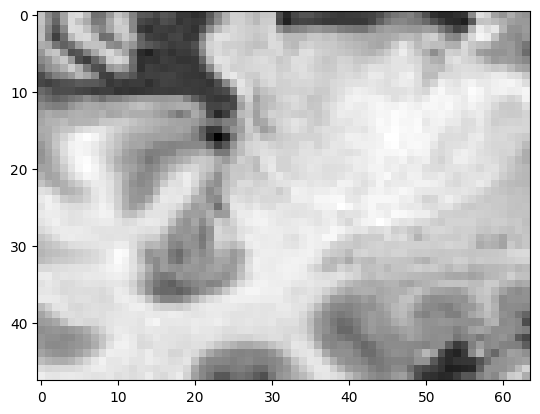

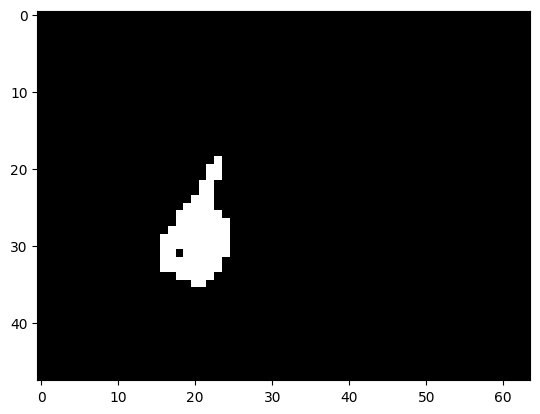

In [644]:
# visualise the images and corresponsing mask for a single case as an image
import matplotlib.pyplot as plt
plt.imshow(dryad_data[7][:,:,30], cmap='gray')
plt.show()
plt.imshow(dryad_labels[7][:,:,30], cmap='gray')
plt.show()

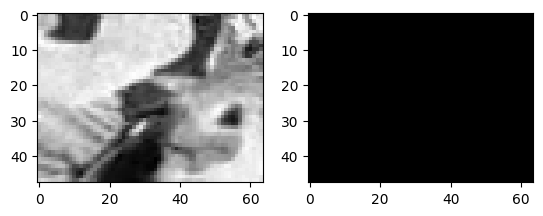

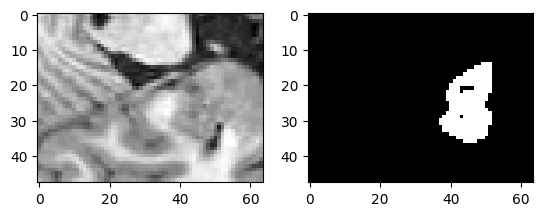

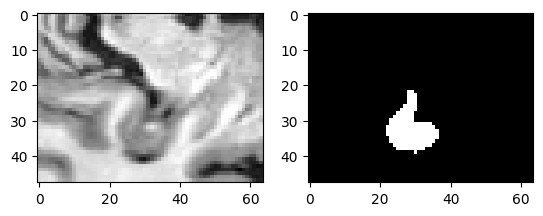

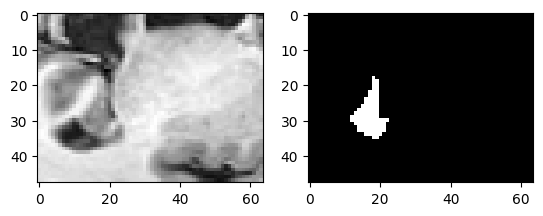

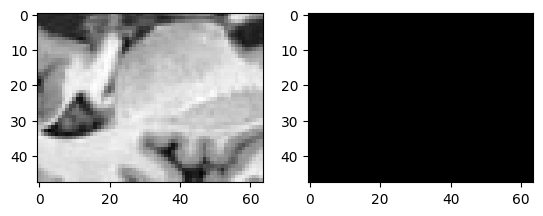

In [645]:
# Specify the range of slices you want to visualize
start_slice = 0
end_slice = 50  # Adjust this based on your data

# Loop through and display the slices and corresponding masks side by side
for slice_num in range(start_slice, end_slice,10):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(dryad_data[3][:, :, slice_num], cmap='gray')
    axarr[1].imshow(dryad_labels[3][:, :, slice_num], cmap='gray')
    plt.show()

### Implement a model for the segmentation task

In [646]:
# determining the shape of the data
print(dryad_data[0].shape)
print(dryad_labels[0].shape)

(48, 64, 64)
(48, 64, 64)


(48, 64, 64)


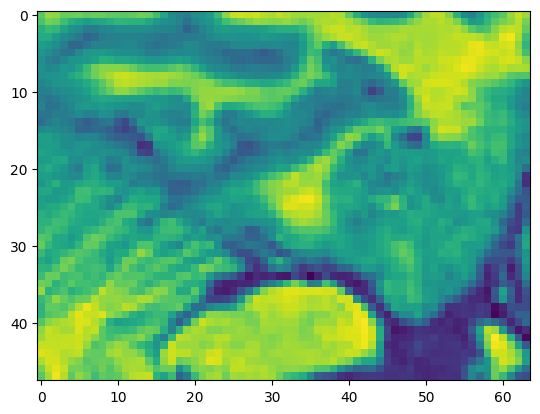

In [647]:
# Load a .nii.gz file
img = nib.load('datasets/Dryad/s01_L.nii.gz')
# Get the image data
img_data = img.get_fdata()
print(img_data.shape)   # (48,64,64)

slice1=(img_data[47,:,:,])
slice2=(img_data[:,50,:])
slice3=(img_data[:,:,10])

plt.figure()
plt.imshow(slice1)
plt.imshow(slice2)
plt.imshow(slice3)
plt.show()

In [648]:
'''DoubleConv is a custom module that defines a block with two convolutional layers followed by batch normalization and ReLU activation.
It's used to create a pair of convolutional layers with normalization and activation.'''
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
'''DownBlock is a custom module that represents the downsampling (contracting) path of the U-Net.
It consists of a DoubleConv block followed by a max-pooling operation to reduce the spatial resolution.
It takes an input tensor, applies convolution and pooling, and returns two outputs: the downsampled feature map and the original 
feature map before downsampling.'''   
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels, out_classes, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(64 + 128, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [649]:
# Define the number of input channels and output classes
in_channels = 48  
out_classes = 48  

# Get UNet model
model = UNet(in_channels,out_classes)

In [650]:
# Define your custom dataset class for loading and preprocessing data
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'image': self.data[idx], 'mask': self.labels[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [651]:
# loss function
# criterion = nn.CrossEntropyLoss()

In [652]:
# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(dryad_data, dryad_labels, test_size=0.3, random_state=42)

# Create data loaders for training and testing
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=10)
test_loader = DataLoader(test_dataset, batch_size=10)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()  # You can use BCE loss as well

In [653]:
# import matplotlib.pyplot as plt

# # Training loop
# num_epochs = 20
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# for epoch in range(num_epochs):
#     model.train()
#     for batch in train_loader:
#         inputs, masks = batch['image'].to(device).float(), batch['mask'].to(device).float()

#         optimizer.zero_grad()
#         outputs = model(inputs)

#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/20, Loss: 4.376059412956238
Epoch 2/20, Loss: 4.2382354736328125
Epoch 3/20, Loss: 4.12531578540802
Epoch 4/20, Loss: 4.023257493972778
Epoch 5/20, Loss: 3.935847759246826
Epoch 6/20, Loss: 3.863885283470154
Epoch 7/20, Loss: 3.803082287311554
Epoch 8/20, Loss: 3.7510788440704346
Epoch 9/20, Loss: 3.7131985425949097
Epoch 10/20, Loss: 3.679651916027069
Epoch 11/20, Loss: 3.6490594148635864
Epoch 12/20, Loss: 3.6165452003479004
Epoch 13/20, Loss: 3.584670305252075
Epoch 14/20, Loss: 3.554347336292267
Epoch 15/20, Loss: 3.5277042388916016
Epoch 16/20, Loss: 3.5019272565841675
Epoch 17/20, Loss: 3.4778117537498474
Epoch 18/20, Loss: 3.455282747745514
Epoch 19/20, Loss: 3.4352232813835144


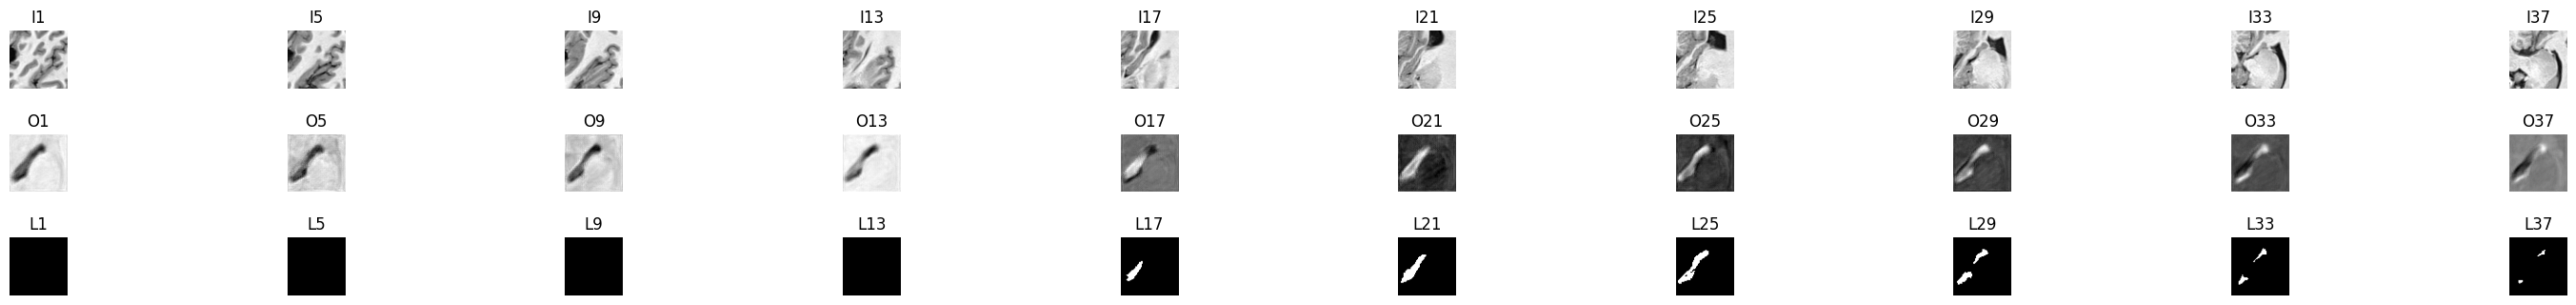

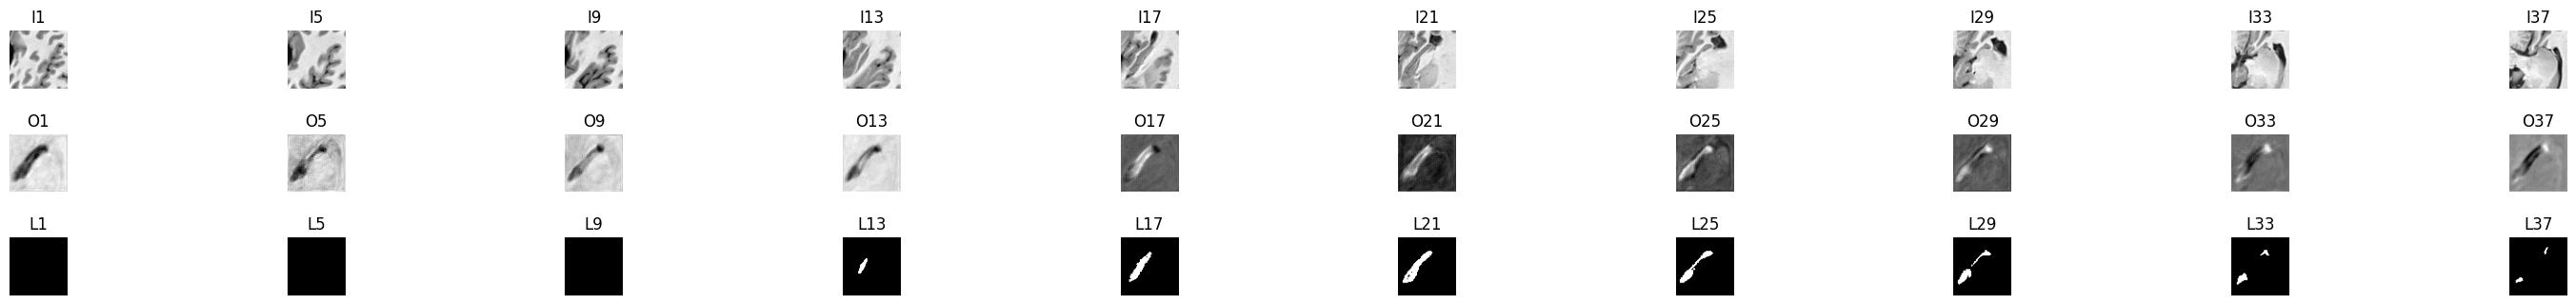

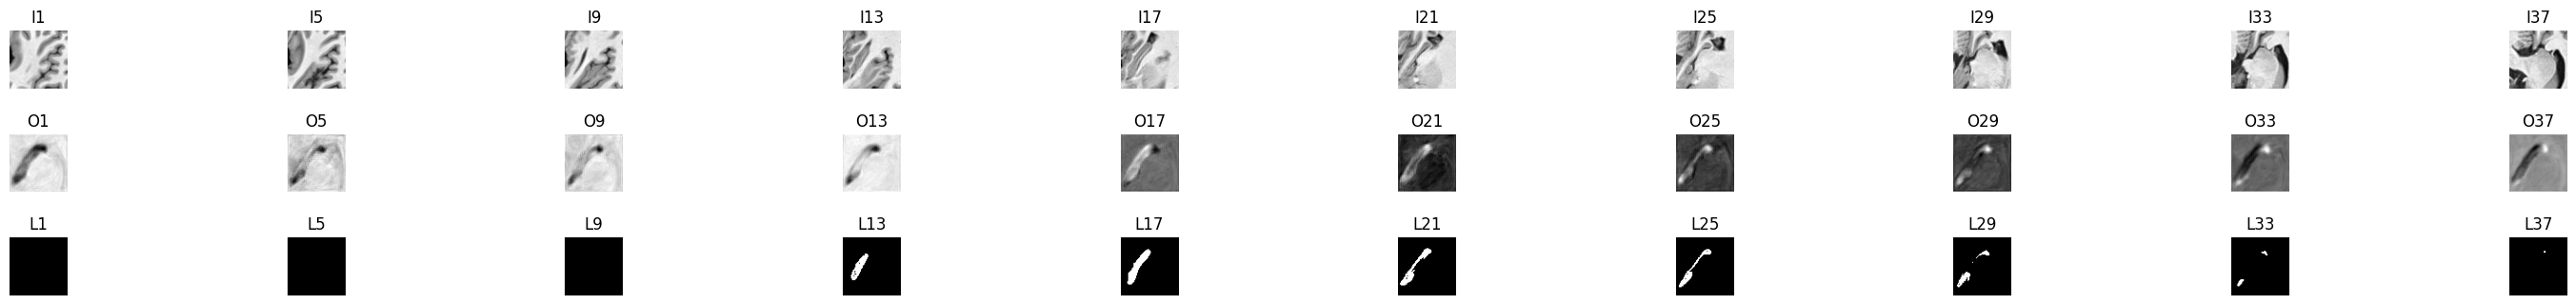

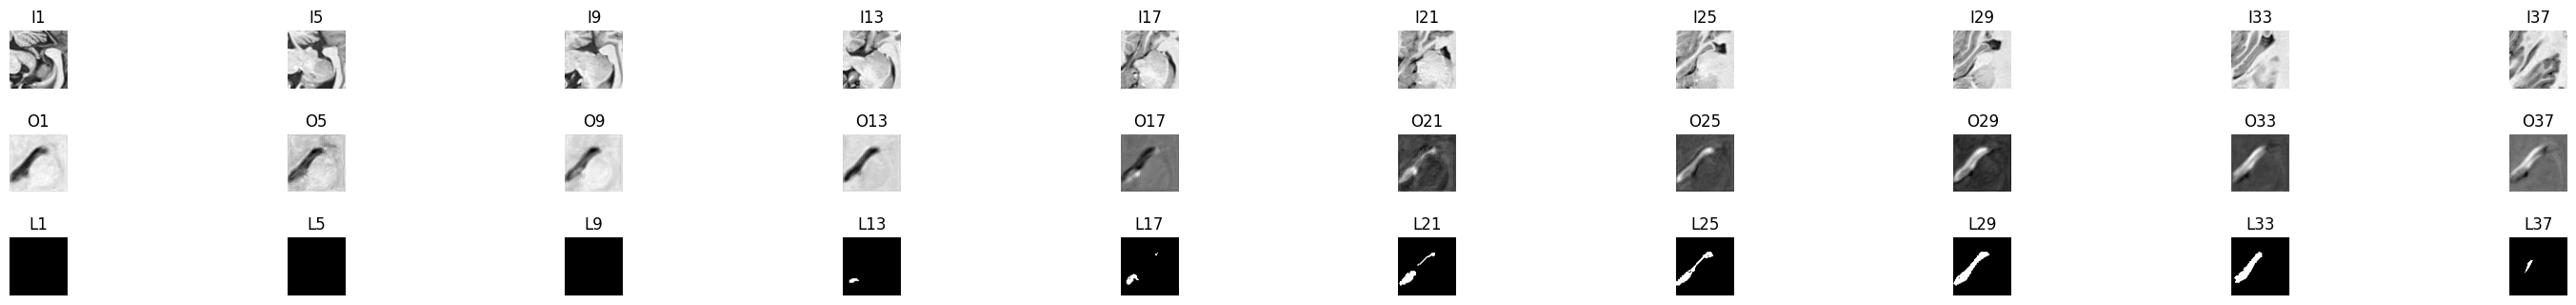

Epoch 20/20, Loss: 3.420007109642029


In [654]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        inputs, masks = batch['image'].to(device).float(), batch['mask'].to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if epoch == num_epochs - 1:
            # Convert tensors to numpy arrays for visualization
            inputs_np = inputs[0].cpu().detach().numpy()  # Input image (shape: [48, 64, 64])
            outputs_np = outputs[0].cpu().detach().numpy()  # Model output (shape: [48, 64, 64])
            masks_np = masks[0].cpu().detach().numpy()  # Label image (shape: [48, 64, 64])

            # Plot the input, output, and label images side by side
            plt.figure(figsize=(45,4))  # Adjust the figure size as needed

            # Plot the input images (all 48 channels)
            for i in range(1,40,4):
                plt.subplot(3, 48, i + 1)  # 3 rows, 48 columns, position 'i + 1'
                plt.imshow(inputs_np[i], cmap='gray')  # Assuming channels are grayscale, adjust colormap if needed
                plt.title(f'I{i}')
                plt.axis('off')  # Turn off axis labels and ticks

            # Plot the model output images (all 48 channels)
            for i in range(1,40,4):
                plt.subplot(3, 48, i + 49)  # 3 rows, 48 columns, position 'i + 49'
                plt.imshow(outputs_np[i], cmap='gray')  # Assuming channels are grayscale, adjust colormap if needed
                plt.title(f'O{i}')
                plt.axis('off')  # Turn off axis labels and ticks

            # Plot the label images (all 48 channels)
            for i in range(1,40,4):
                plt.subplot(3, 48, i + 97)  # 3 rows, 48 columns, position 'i + 97'
                plt.imshow(masks_np[i], cmap='gray')  # Assuming channels are grayscale, adjust colormap if needed
                plt.title(f'L{i}')
                plt.axis('off')  # Turn off axis labels and ticks

            plt.show()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}')

In [666]:
def visualize_results(input_image, ground_truth_mask, predicted_mask):
    # Convert tensors to NumPy arrays
    # input_image = input_image..cpu().detach().numpy()
    # ground_truth_mask = ground_truth_mask..cpu().detach().numpy()
    # predicted_mask = predicted_mask..cpu().detach().numpy()

    # Create subplots for input, ground truth, and predicted masks
    # Plot the input, output, and label images side by side
    plt.figure(figsize=(45,4))  # Adjust the figure size as needed

    # Plot the input images (all 48 channels)
    for i in range(1,40,4):
        plt.subplot(3, 48, i + 1)  # 3 rows, 48 columns, position 'i + 1'
        plt.imshow(input_image[i], cmap='gray')  # Assuming channels are grayscale, adjust colormap if needed
        plt.title(f'I{i}')
        plt.axis('off')  # Turn off axis labels and ticks

    # Plot the model output images (all 48 channels)
    for i in range(1,40,4):
        plt.subplot(3, 48, i + 49)  # 3 rows, 48 columns, position 'i + 49'
        plt.imshow(predicted_mask[i], cmap='gray')  # Assuming channels are grayscale, adjust colormap if needed
        plt.title(f'O{i}')
        plt.axis('off')  # Turn off axis labels and ticks

    # Plot the label images (all 48 channels)
    for i in range(1,40,4):
        plt.subplot(3, 48, i + 97)  # 3 rows, 48 columns, position 'i + 97'
        plt.imshow(ground_truth_mask[i], cmap='gray')  # Assuming channels are grayscale, adjust colormap if needed
        plt.title(f'L{i}')
        plt.axis('off')  # Turn off axis labels and ticks

    plt.show()
    
    plt.show()

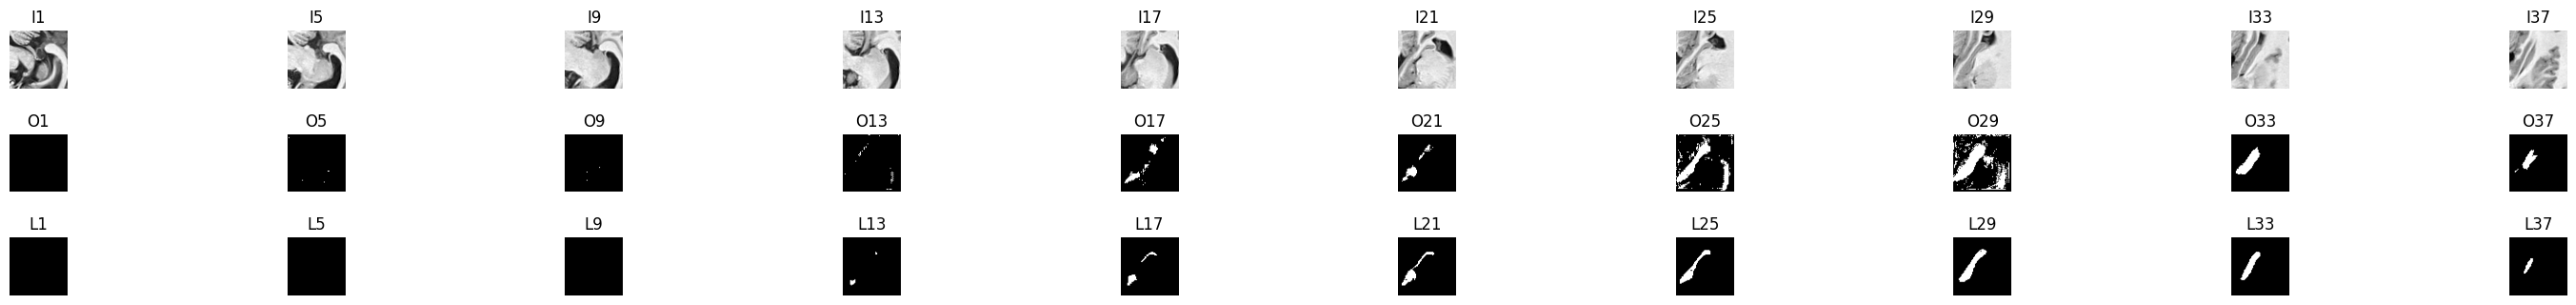

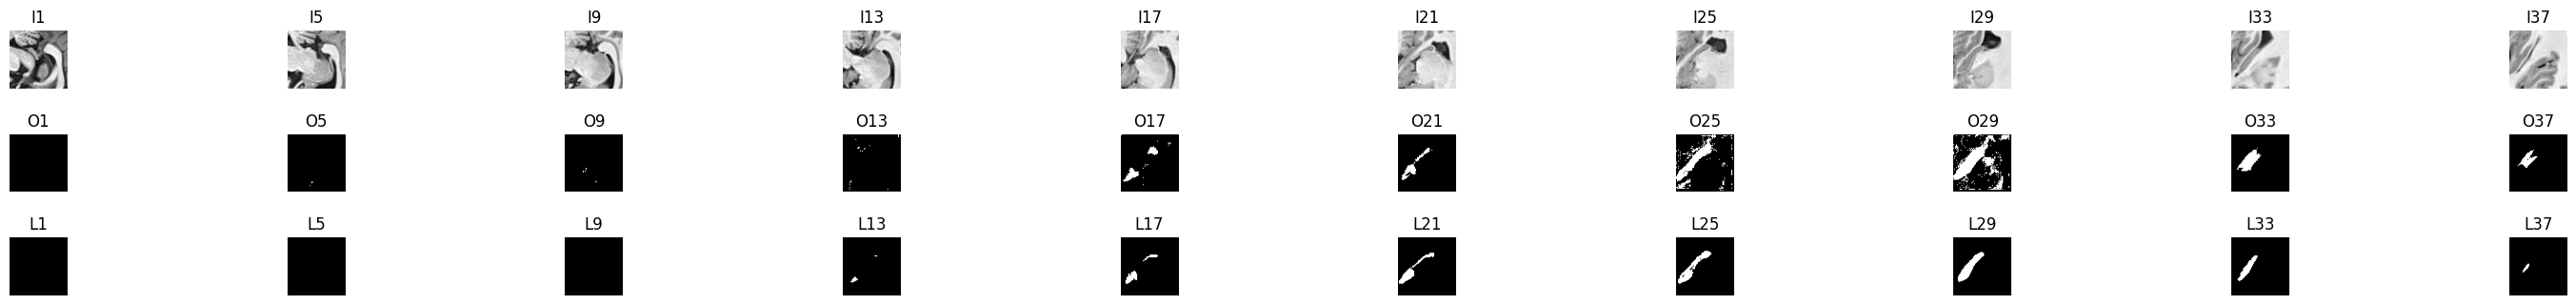

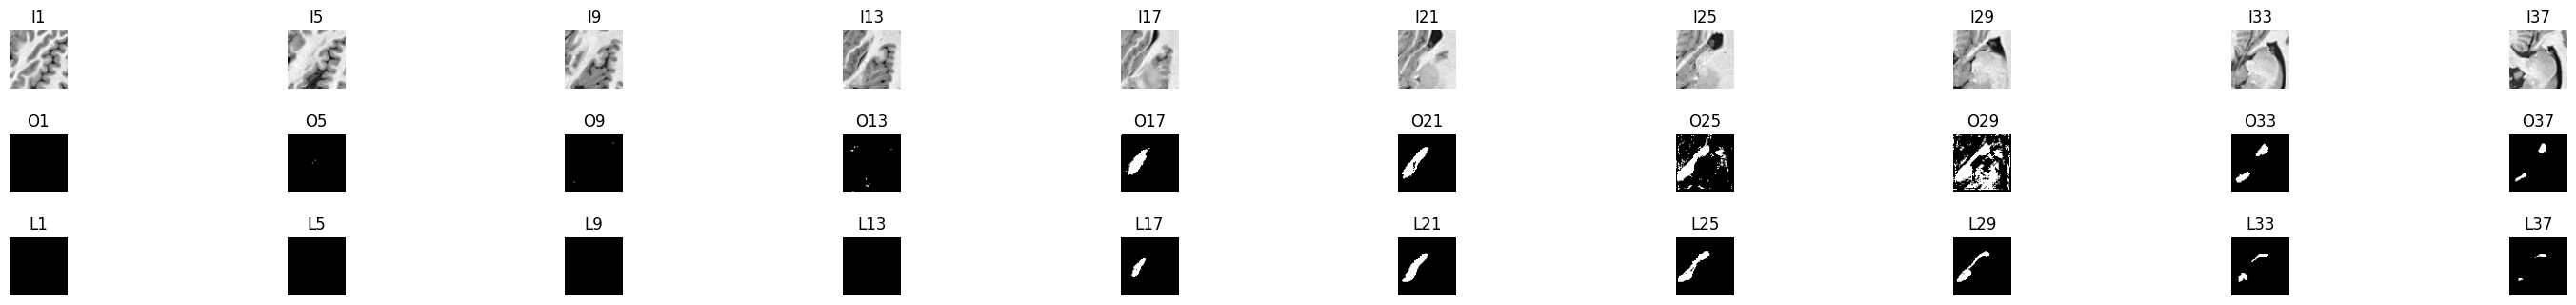

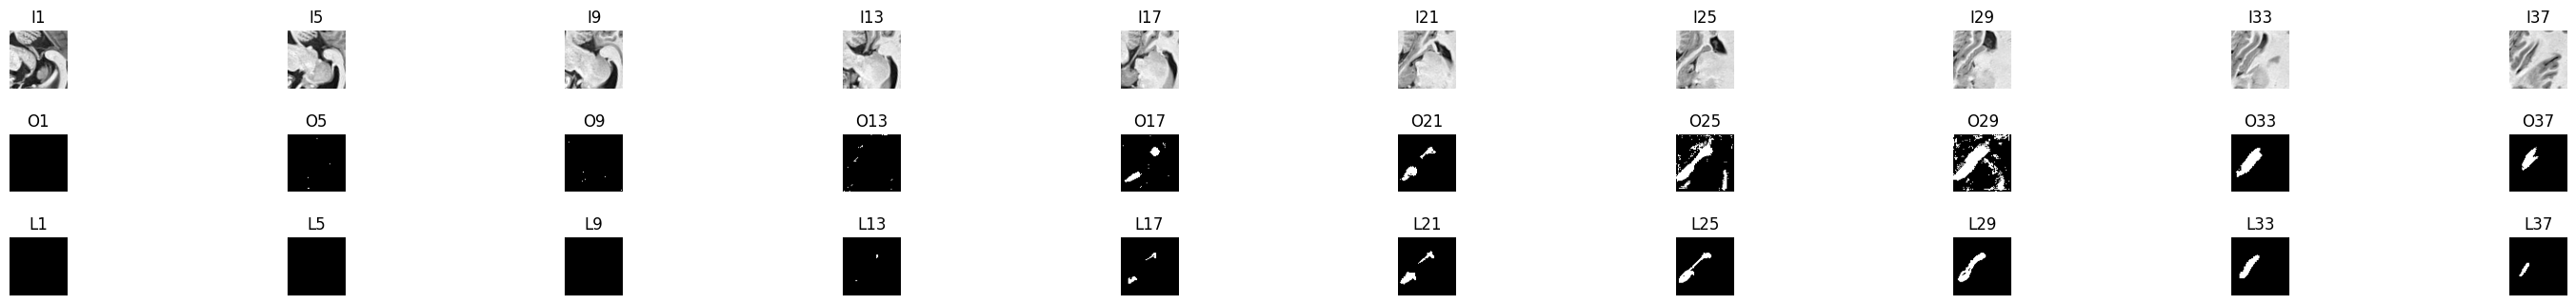

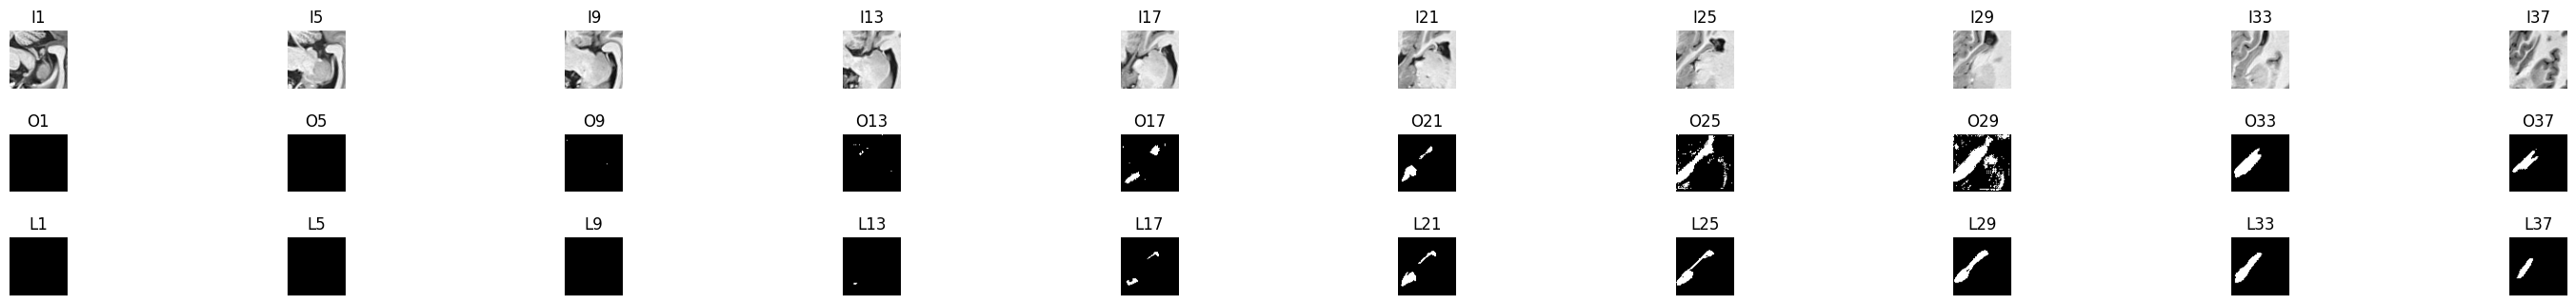

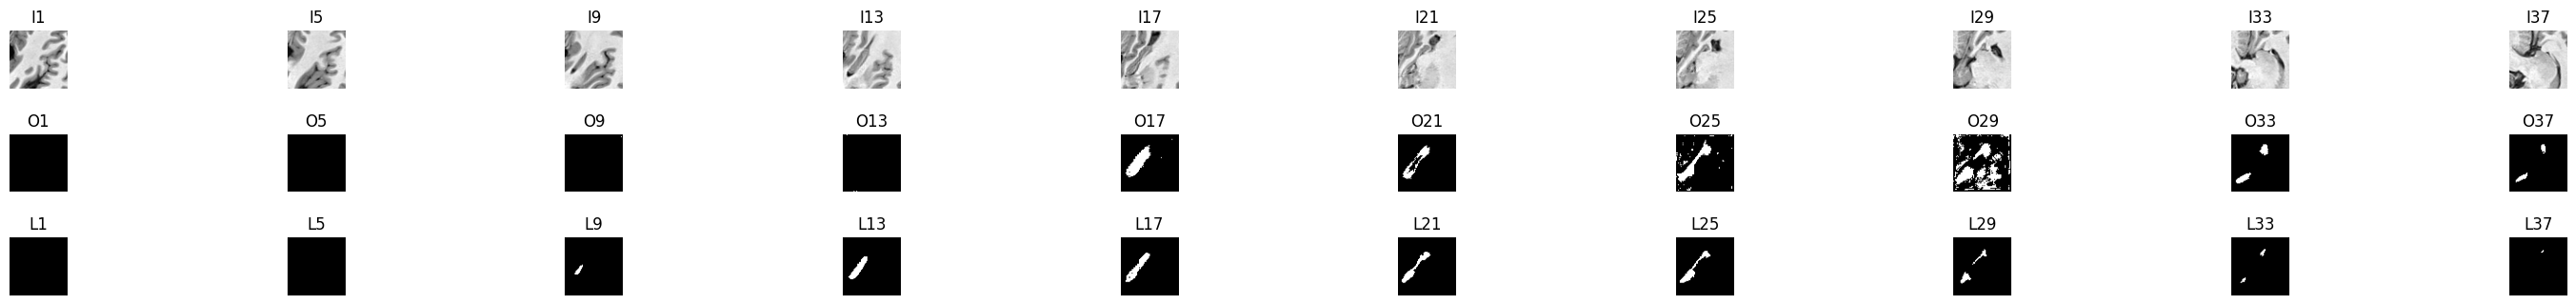

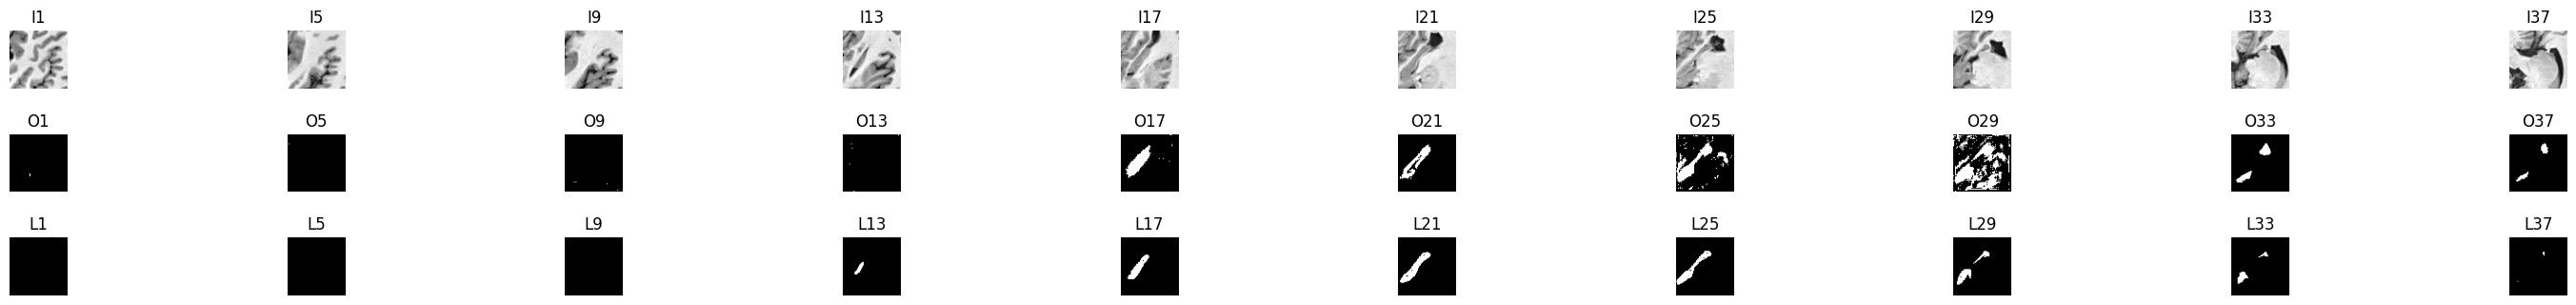

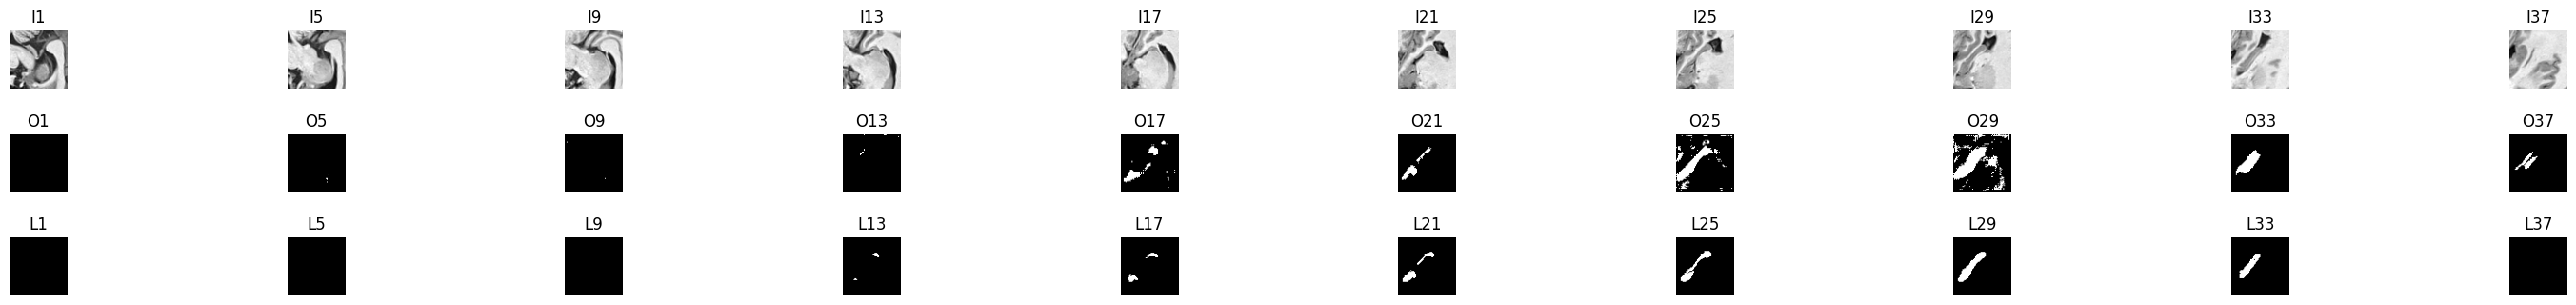

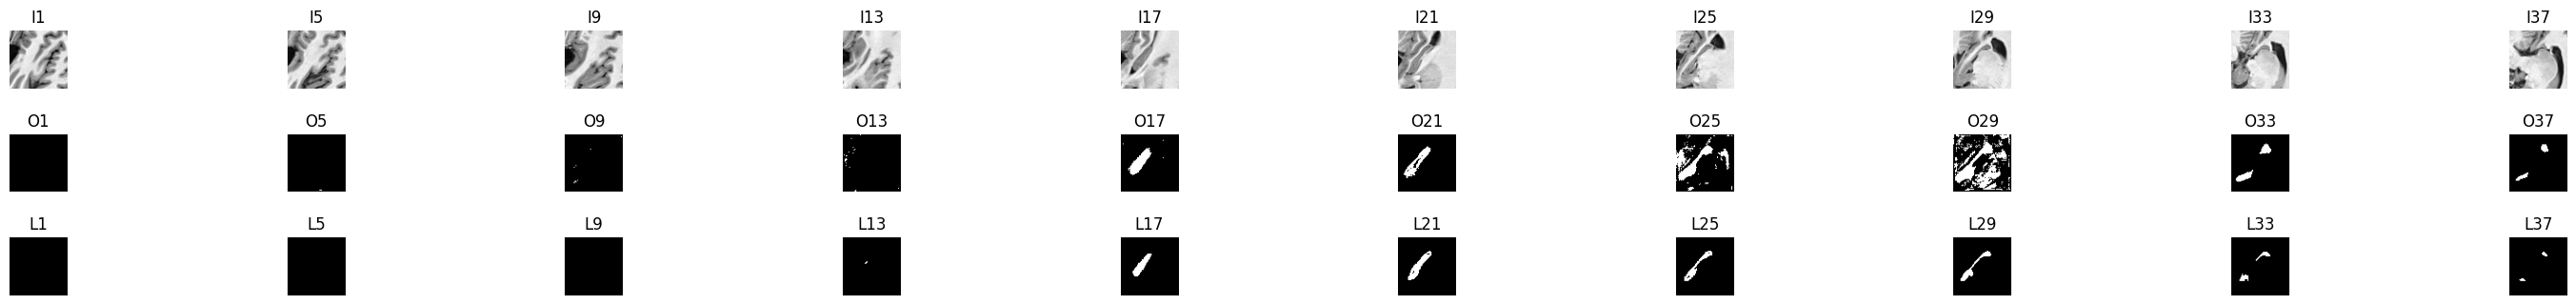

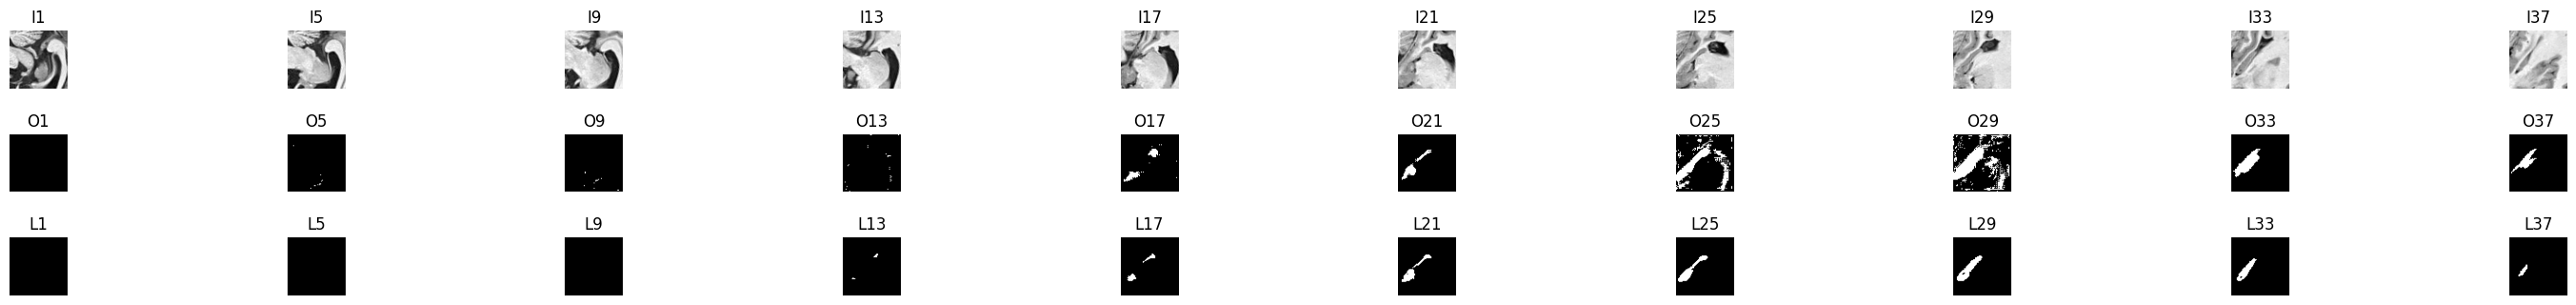

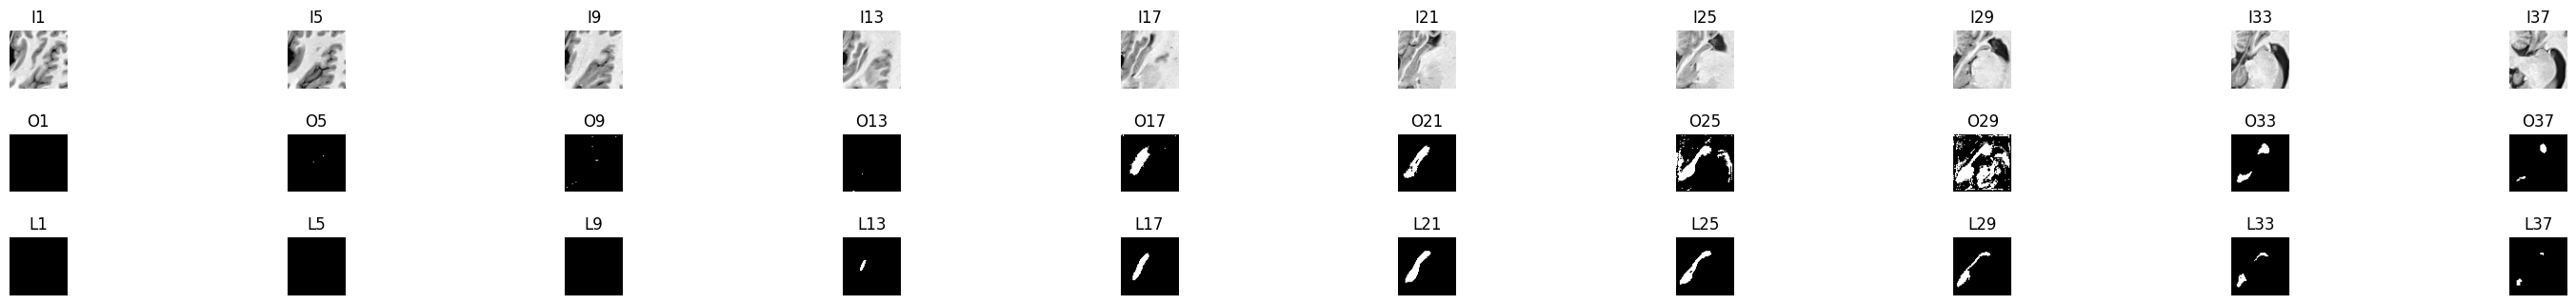

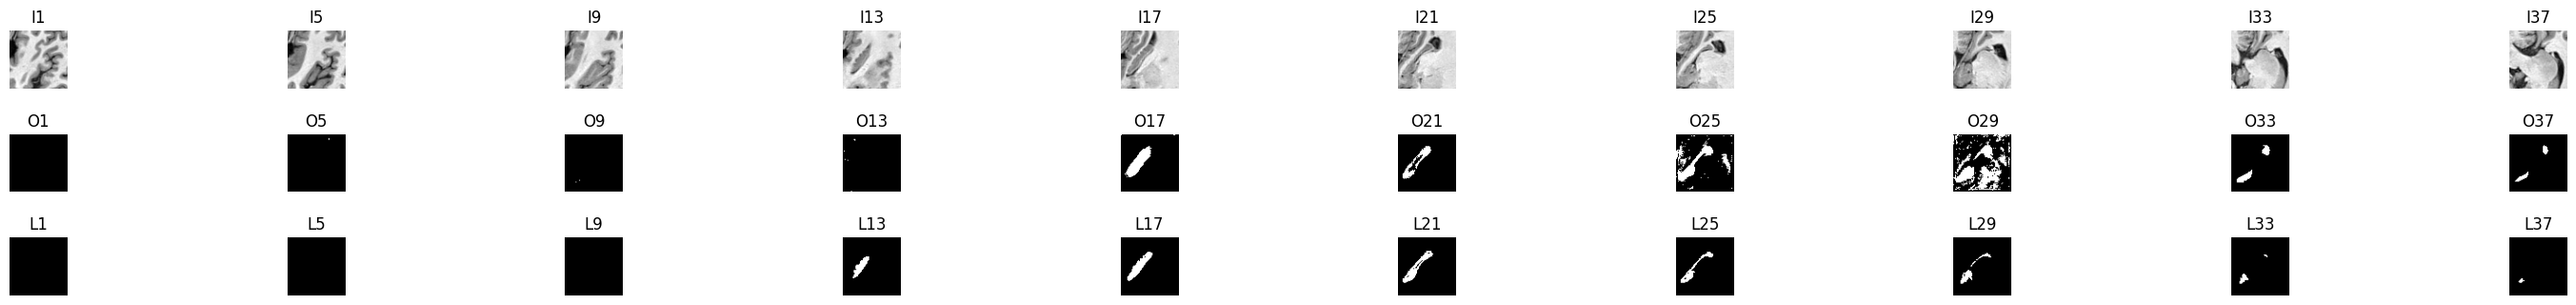

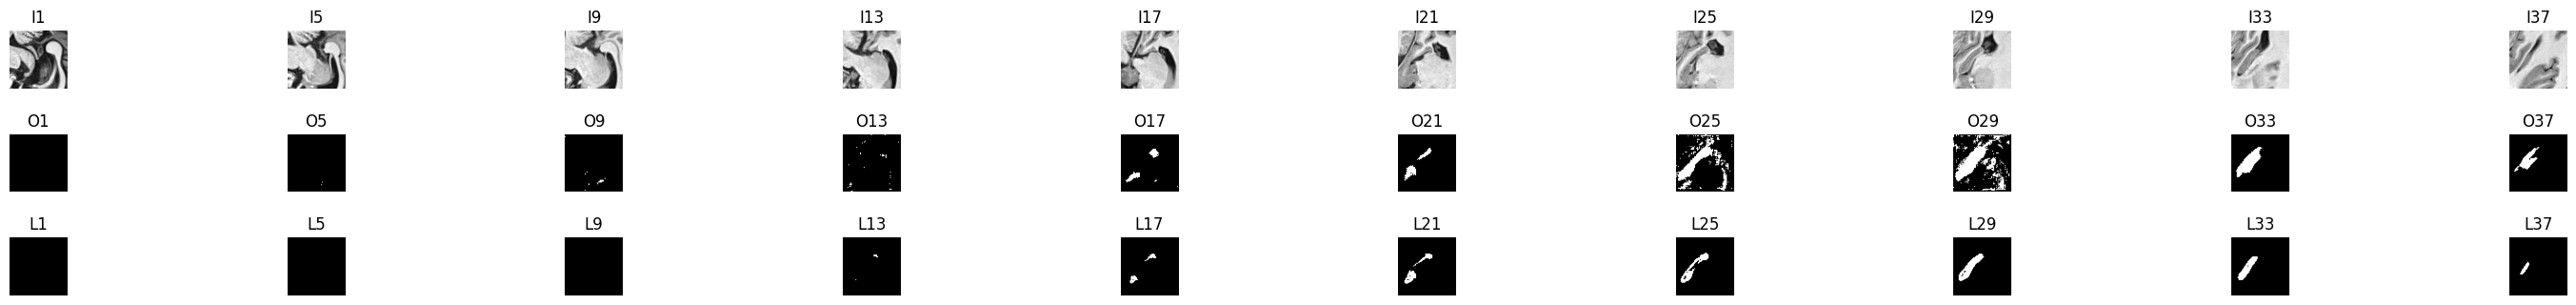

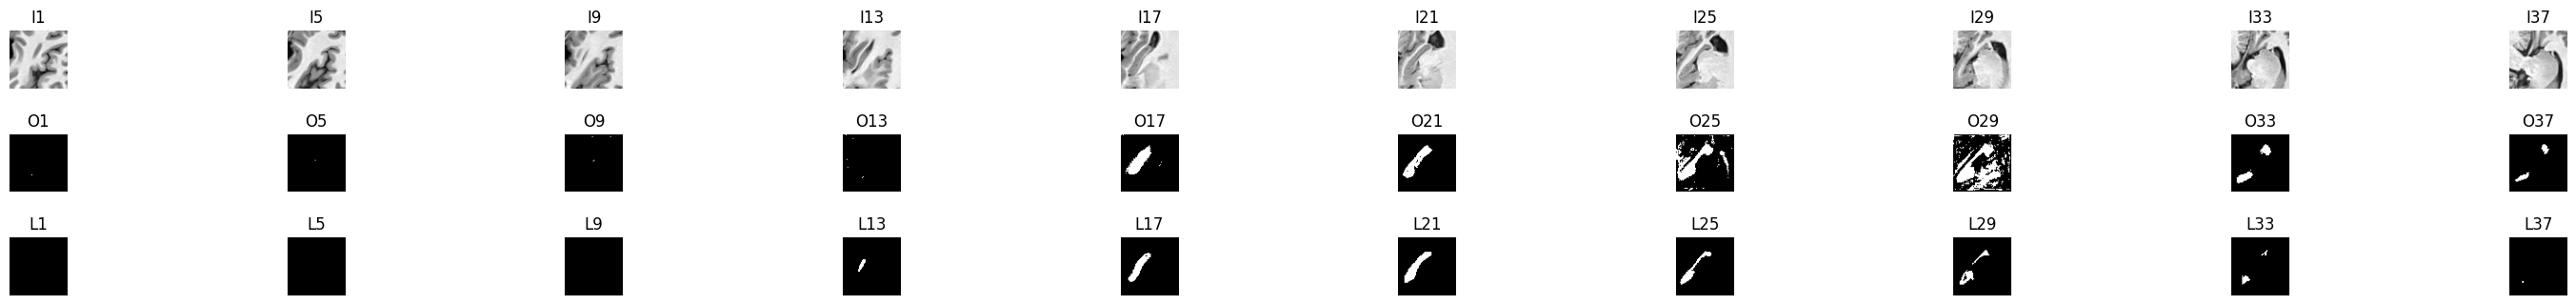

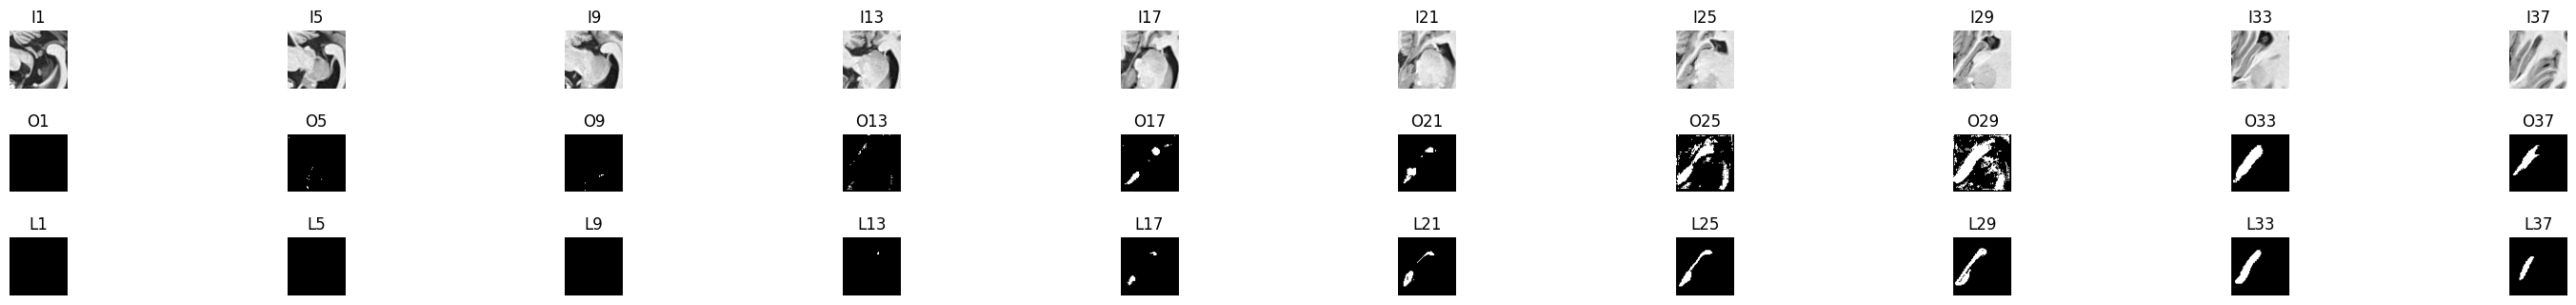

In [667]:
# Iterate through test data
for test_sample in test_loader:
    inputs_batch = test_sample['image'].to(device).float()
    
    for i in range(inputs_batch.shape[0]):
        input_image = inputs_batch[i]  # Get a single image from the batch
        
        # Forward pass through the model
        with torch.no_grad():  # No need to compute gradients during inference
            output = model(input_image.unsqueeze(0))  # Add a batch dimension
        
        predicted_mask = (output > 0.5).float().squeeze().cpu().numpy()
        
        # Visualize the input, ground truth, and predicted results (you can use libraries like Matplotlib)
        visualize_results(input_image.cpu().numpy(), test_sample['mask'][i].cpu().numpy(), predicted_mask)
